In [15]:
import numpy as np
import pandas as pd
import os
import requests
import zipfile
from sklearn.model_selection import train_test_split

## Download and extract data files
def download_and_extract():
	url = "https://archive.ics.uci.edu/ml/machine-learning-databases/00319/MHEALTHDATASET.zip"
	print("Downloading..")
	r = requests.get(url)

	# Write into file
	open('MHEALTHDATASET.zip','wb').write(r.content)

	# Extract
	print('Extracting...')
	zip_h = zipfile.ZipFile('MHEALTHDATASET.zip','r')
	zip_h.extractall()
	zip_h.close()

	# Rename and remove zip
	os.rename('MHEALTHDATASET', 'data')
	os.remove('MHEALTHDATASET.zip')

## Read data per subject
def read_subject(subject):
	""" Read measurements from a given subject """
	file_name = 'mHealth_subject' + str(subject) + '.log'
	file_path = os.path.join('data',file_name)


	# Read file
	try:
		df = pd.read_csv(file_path, delim_whitespace = True, header = None)
	except IOError:
		print("Data file does not exist!")

	# Remove data with null class (=0)
	df = df[df[23] != 0]

	return df

## Rewrite a sequence for a given subject in tensor format
def split_by_blocks(df, block_size=100):
	""" Split data from each subject into blocks of shorter length """

	# Channels
	n_channels = df.shape[1]-1

	# Group by labels 
	grps = df.groupby(23)
	
	# Create a list for concatenating
	X_ = []
	Y_ = []

	# Loop over groups (labels), reshape to tensor and concatenate
	for ig in range(1,len(grps)+1,1):
		df_ = grps.get_group(ig)

		# Data and targets
		y = pd.unique(df_[23].values)
		x = df_.drop(23, axis=1).to_numpy()

		n_blocks = len(x) // block_size
		x = x[:n_blocks*block_size]
		y = y[:n_blocks*block_size]
		#print(np.shape(x))
        #print(x)
		x_tensor = x.reshape(-1, block_size, n_channels)

		# Append
		X_.append(x_tensor)
		Y_.append(np.array([y]*len(x_tensor), dtype=int).squeeze())

	# Concatenate and return
	X = np.concatenate(X_, axis=0)
	Y = np.concatenate(Y_, axis=0)

	return X, Y

## Merge all the subjects and save into file
def collect_save_data(subject_count = 10, block_size=100):
	""" Collects all the data from all the subjects and writes in file """

	# Initiate lists
	X_ = []
	Y_ = []
	for s in range(1,subject_count+1):
		# Read the data
		df = read_subject(s)
    
	#return df
		# Split into blocks
		x,y = split_by_blocks(df, block_size)

		# Add to list
		X_.append(x)
		Y_.append(y)

	# Concatenate and save
	X = np.concatenate(X_, axis=0)
	Y = np.concatenate(Y_, axis=0)

	# Save 
	np.save(os.path.join('data','dataX.npy'), X)
	np.save(os.path.join('data','dataY.npy'), Y)


## One-hot encoding
def one_hot(labels, n_class = 12):
	""" One-hot encoding """
	expansion = np.eye(n_class)
	y = expansion[:,labels-1].T

	return y

## Standardize
def standardize(X):
	""" Standardize by mean and std for each measurement channel"""
	return (X - np.mean(X, axis=0)[None,:,:]) / np.std(X, axis=0)[None,:,:]

## Get batches
def get_batches(X, y, batch_size = 100):
	""" Yield batches ffrom data """
	n_batches = len(X) // batch_size
	X, y = X[:n_batches*batch_size], y[:n_batches*batch_size]

	# Loop over batches and yield
	for b in range(0, len(X), batch_size):
		yield X[b:b+batch_size], y[b:b+batch_size]

In [16]:
collect_save_data()

In [18]:
# Imports
#from utils.utils import *
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
%matplotlib inline

In [19]:

# Read 
X = np.load('./data/dataX.npy')
Y = np.load('./data/dataY.npy')

print("Number of instances: ", X.shape[0])
print("Length of sequence: ", X.shape[1])
print("Number of channels: ", X.shape[2])

Number of instances:  3355
Length of sequence:  100
Number of channels:  23


In [20]:
# Train/test
X_tr, X_test, Y_tr, Y_test = train_test_split(X,Y, test_size=0.3, stratify=Y, random_state=123)

# Standardize
X_tr = standardize(X_tr); X_test = standardize(X_test)

# Train/validation
X_train, X_valid, Y_train, Y_valid = train_test_split(X_tr, Y_tr, test_size=0.4, stratify=Y_tr, random_state=456)

# One-hot encode
y_train = one_hot(Y_train, n_class=12)
y_valid = one_hot(Y_valid, n_class=12)
y_test = one_hot(Y_test, n_class=12)

In [21]:
print("Training set size: ", len(X_train))
print("Validaton set size: ", len(X_valid))
print("Test set size: ", len(X_test))

Training set size:  1408
Validaton set size:  940
Test set size:  1007


# BUILDING TENSORFLOW

In [23]:
# Imports
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()

# Hyperparameters
batch_size = 400       
seq_len = 100       
learning_rate = 0.0001
epochs = 1000

n_classes = 12
n_channels = 23

# Placeholders
graph = tf.Graph()

# Construct placeholders
with graph.as_default():
    inputs_ = tf.placeholder(tf.float32, [None, seq_len, n_channels], name = 'inputs')
    labels_ = tf.placeholder(tf.float32, [None, n_classes], name = 'labels')
    keep_prob_ = tf.placeholder(tf.float32, name = 'keep')
    learning_rate_ = tf.placeholder(tf.float32, name = 'learning_rate')

Instructions for updating:
non-resource variables are not supported in the long term


# BUILDING CONVOLUTION LAYER

In [24]:
with graph.as_default():
    # (batch, 100, 23) --> (batch, 50, 46)
    conv1 = tf.layers.conv1d(inputs=inputs_, filters=46, kernel_size=2, strides=1, 
                             padding='same', activation = tf.nn.relu)
    max_pool_1 = tf.layers.max_pooling1d(inputs=conv1, pool_size=2, strides=2, padding='same')
    
    # (batch, 50, 46) --> (batch, 25, 92)
    conv2 = tf.layers.conv1d(inputs=max_pool_1, filters=92, kernel_size=2, strides=1, 
                             padding='same', activation = tf.nn.relu)
    max_pool_2 = tf.layers.max_pooling1d(inputs=conv2, pool_size=2, strides=2, padding='same')
    
    # (batch, 25, 92) --> (batch, 5, 184)
    conv3 = tf.layers.conv1d(inputs=max_pool_2, filters=184, kernel_size=5, strides=1, 
                             padding='same', activation = tf.nn.relu)
    max_pool_3 = tf.layers.max_pooling1d(inputs=conv3, pool_size=5, strides=5, padding='same')

Instructions for updating:
Use `tf.keras.layers.Conv1D` instead.
Instructions for updating:
Please use `layer.__call__` method instead.
Instructions for updating:
Use keras.layers.MaxPooling1D instead.


# FLATTEN AND PASS TO CLASSIFIER

In [26]:
with graph.as_default():
    # Flatten and add dropout
    flat = tf.reshape(max_pool_3, (-1, 5*184))
    flat = tf.nn.dropout(flat, keep_prob=keep_prob_)
    
    # Predictions
    logits = tf.layers.dense(flat, n_classes)
    
    # Cost function and optimizer
    cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=labels_))
    optimizer = tf.train.AdamOptimizer(learning_rate_).minimize(cost)
    
    # Accuracy
    correct_pred = tf.equal(tf.argmax(logits, 1), tf.argmax(labels_, 1))
    accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32), name='accuracy')

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use keras.layers.Dense instead.
Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See `tf.nn.softmax_cross_entropy_with_logits_v2`.



# TRAIN THE NETWORK

In [27]:
if (os.path.exists('checkpoints-cnn') == False):
    !mkdir checkpoints-cnn
    
validation_acc = []
validation_loss = []

train_acc = []
train_loss = []

with graph.as_default():
    saver = tf.train.Saver()

with tf.Session(graph=graph) as sess:
    sess.run(tf.global_variables_initializer())
    iteration = 1
   
    # Loop over epochs
    for e in range(epochs):
        
        # Loop over batches
        for x,y in get_batches(X_train, y_train, batch_size):
            
            # Feed dictionary
            feed = {inputs_ : x, labels_ : y, keep_prob_ : 0.5, learning_rate_ : learning_rate}
            
            # Loss
            loss, _ , acc = sess.run([cost, optimizer, accuracy], feed_dict = feed)
            train_acc.append(acc)
            train_loss.append(loss)
            
            # Print at each 5 iters
            if (iteration % 5 == 0):
                print("Epoch: {}/{}".format(e, epochs),
                      "Iteration: {:d}".format(iteration),
                      "Train loss: {:6f}".format(loss),
                      "Train acc: {:.6f}".format(acc))
            
            # Compute validation loss at every 10 iterations
            if (iteration%10 == 0):                
                val_acc_ = []
                val_loss_ = []
                
                for x_v, y_v in get_batches(X_valid, y_valid, batch_size):
                    # Feed
                    feed = {inputs_ : x_v, labels_ : y_v, keep_prob_ : 1.0}  
                    
                    # Loss
                    loss_v, acc_v = sess.run([cost, accuracy], feed_dict = feed)                    
                    val_acc_.append(acc_v)
                    val_loss_.append(loss_v)
                
                # Print info
                print("Epoch: {}/{}".format(e, epochs),
                      "Iteration: {:d}".format(iteration),
                      "Validation loss: {:6f}".format(np.mean(val_loss_)),
                      "Validation acc: {:.6f}".format(np.mean(val_acc_)))
                
                # Store
                validation_acc.append(np.mean(val_acc_))
                validation_loss.append(np.mean(val_loss_))
            
            # Iterate 
            iteration += 1
    
    saver.save(sess,"checkpoints-cnn/mHealth.ckpt")

Epoch: 1/1000 Iteration: 5 Train loss: 2.531578 Train acc: 0.107500
Epoch: 3/1000 Iteration: 10 Train loss: 2.398342 Train acc: 0.115000
Epoch: 3/1000 Iteration: 10 Validation loss: 2.275611 Validation acc: 0.101250
Epoch: 4/1000 Iteration: 15 Train loss: 2.357396 Train acc: 0.152500
Epoch: 6/1000 Iteration: 20 Train loss: 2.183769 Train acc: 0.215000
Epoch: 6/1000 Iteration: 20 Validation loss: 2.143206 Validation acc: 0.235000
Epoch: 8/1000 Iteration: 25 Train loss: 2.201128 Train acc: 0.245000
Epoch: 9/1000 Iteration: 30 Train loss: 2.066445 Train acc: 0.302500
Epoch: 9/1000 Iteration: 30 Validation loss: 2.025039 Validation acc: 0.310000
Epoch: 11/1000 Iteration: 35 Train loss: 2.001466 Train acc: 0.335000
Epoch: 13/1000 Iteration: 40 Train loss: 2.023512 Train acc: 0.332500
Epoch: 13/1000 Iteration: 40 Validation loss: 1.909965 Validation acc: 0.345000
Epoch: 14/1000 Iteration: 45 Train loss: 1.938154 Train acc: 0.325000
Epoch: 16/1000 Iteration: 50 Train loss: 1.825171 Train acc:

Epoch: 124/1000 Iteration: 375 Train loss: 0.138322 Train acc: 0.975000
Epoch: 126/1000 Iteration: 380 Train loss: 0.158017 Train acc: 0.965000
Epoch: 126/1000 Iteration: 380 Validation loss: 0.146471 Validation acc: 0.972500
Epoch: 128/1000 Iteration: 385 Train loss: 0.141209 Train acc: 0.967500
Epoch: 129/1000 Iteration: 390 Train loss: 0.135942 Train acc: 0.972500
Epoch: 129/1000 Iteration: 390 Validation loss: 0.140583 Validation acc: 0.972500
Epoch: 131/1000 Iteration: 395 Train loss: 0.118072 Train acc: 0.982500
Epoch: 133/1000 Iteration: 400 Train loss: 0.142891 Train acc: 0.967500
Epoch: 133/1000 Iteration: 400 Validation loss: 0.136256 Validation acc: 0.973750
Epoch: 134/1000 Iteration: 405 Train loss: 0.107045 Train acc: 0.980000
Epoch: 136/1000 Iteration: 410 Train loss: 0.118913 Train acc: 0.980000
Epoch: 136/1000 Iteration: 410 Validation loss: 0.126788 Validation acc: 0.976250
Epoch: 138/1000 Iteration: 415 Train loss: 0.122609 Train acc: 0.977500
Epoch: 139/1000 Iteratio

Epoch: 246/1000 Iteration: 740 Train loss: 0.025101 Train acc: 1.000000
Epoch: 246/1000 Iteration: 740 Validation loss: 0.051221 Validation acc: 0.987500
Epoch: 248/1000 Iteration: 745 Train loss: 0.033092 Train acc: 0.995000
Epoch: 249/1000 Iteration: 750 Train loss: 0.020234 Train acc: 1.000000
Epoch: 249/1000 Iteration: 750 Validation loss: 0.051563 Validation acc: 0.988750
Epoch: 251/1000 Iteration: 755 Train loss: 0.020615 Train acc: 1.000000
Epoch: 253/1000 Iteration: 760 Train loss: 0.037252 Train acc: 0.985000
Epoch: 253/1000 Iteration: 760 Validation loss: 0.049590 Validation acc: 0.988750
Epoch: 254/1000 Iteration: 765 Train loss: 0.030248 Train acc: 0.995000
Epoch: 256/1000 Iteration: 770 Train loss: 0.028015 Train acc: 0.992500
Epoch: 256/1000 Iteration: 770 Validation loss: 0.048690 Validation acc: 0.990000
Epoch: 258/1000 Iteration: 775 Train loss: 0.023812 Train acc: 1.000000
Epoch: 259/1000 Iteration: 780 Train loss: 0.021219 Train acc: 0.995000
Epoch: 259/1000 Iteratio

Epoch: 368/1000 Iteration: 1105 Train loss: 0.010490 Train acc: 1.000000
Epoch: 369/1000 Iteration: 1110 Train loss: 0.009767 Train acc: 1.000000
Epoch: 369/1000 Iteration: 1110 Validation loss: 0.036473 Validation acc: 0.990000
Epoch: 371/1000 Iteration: 1115 Train loss: 0.009993 Train acc: 1.000000
Epoch: 373/1000 Iteration: 1120 Train loss: 0.010193 Train acc: 1.000000
Epoch: 373/1000 Iteration: 1120 Validation loss: 0.036104 Validation acc: 0.990000
Epoch: 374/1000 Iteration: 1125 Train loss: 0.006651 Train acc: 1.000000
Epoch: 376/1000 Iteration: 1130 Train loss: 0.012309 Train acc: 1.000000
Epoch: 376/1000 Iteration: 1130 Validation loss: 0.035741 Validation acc: 0.990000
Epoch: 378/1000 Iteration: 1135 Train loss: 0.014050 Train acc: 0.997500
Epoch: 379/1000 Iteration: 1140 Train loss: 0.012390 Train acc: 0.997500
Epoch: 379/1000 Iteration: 1140 Validation loss: 0.036394 Validation acc: 0.988750
Epoch: 381/1000 Iteration: 1145 Train loss: 0.008230 Train acc: 1.000000
Epoch: 383/

Epoch: 488/1000 Iteration: 1465 Train loss: 0.004962 Train acc: 1.000000
Epoch: 489/1000 Iteration: 1470 Train loss: 0.004372 Train acc: 1.000000
Epoch: 489/1000 Iteration: 1470 Validation loss: 0.031037 Validation acc: 0.992500
Epoch: 491/1000 Iteration: 1475 Train loss: 0.003570 Train acc: 1.000000
Epoch: 493/1000 Iteration: 1480 Train loss: 0.004401 Train acc: 1.000000
Epoch: 493/1000 Iteration: 1480 Validation loss: 0.031225 Validation acc: 0.991250
Epoch: 494/1000 Iteration: 1485 Train loss: 0.003763 Train acc: 1.000000
Epoch: 496/1000 Iteration: 1490 Train loss: 0.005135 Train acc: 1.000000
Epoch: 496/1000 Iteration: 1490 Validation loss: 0.031231 Validation acc: 0.991250
Epoch: 498/1000 Iteration: 1495 Train loss: 0.004338 Train acc: 1.000000
Epoch: 499/1000 Iteration: 1500 Train loss: 0.007908 Train acc: 1.000000
Epoch: 499/1000 Iteration: 1500 Validation loss: 0.030883 Validation acc: 0.992500
Epoch: 501/1000 Iteration: 1505 Train loss: 0.004738 Train acc: 1.000000
Epoch: 503/

Epoch: 608/1000 Iteration: 1825 Train loss: 0.002459 Train acc: 1.000000
Epoch: 609/1000 Iteration: 1830 Train loss: 0.003052 Train acc: 1.000000
Epoch: 609/1000 Iteration: 1830 Validation loss: 0.029854 Validation acc: 0.991250
Epoch: 611/1000 Iteration: 1835 Train loss: 0.003677 Train acc: 1.000000
Epoch: 613/1000 Iteration: 1840 Train loss: 0.005447 Train acc: 0.997500
Epoch: 613/1000 Iteration: 1840 Validation loss: 0.030444 Validation acc: 0.991250
Epoch: 614/1000 Iteration: 1845 Train loss: 0.002306 Train acc: 1.000000
Epoch: 616/1000 Iteration: 1850 Train loss: 0.002546 Train acc: 1.000000
Epoch: 616/1000 Iteration: 1850 Validation loss: 0.029318 Validation acc: 0.991250
Epoch: 618/1000 Iteration: 1855 Train loss: 0.003655 Train acc: 1.000000
Epoch: 619/1000 Iteration: 1860 Train loss: 0.002453 Train acc: 1.000000
Epoch: 619/1000 Iteration: 1860 Validation loss: 0.028839 Validation acc: 0.992500
Epoch: 621/1000 Iteration: 1865 Train loss: 0.002814 Train acc: 1.000000
Epoch: 623/

Epoch: 728/1000 Iteration: 2185 Train loss: 0.002728 Train acc: 1.000000
Epoch: 729/1000 Iteration: 2190 Train loss: 0.001973 Train acc: 1.000000
Epoch: 729/1000 Iteration: 2190 Validation loss: 0.027149 Validation acc: 0.991250
Epoch: 731/1000 Iteration: 2195 Train loss: 0.001687 Train acc: 1.000000
Epoch: 733/1000 Iteration: 2200 Train loss: 0.002447 Train acc: 1.000000
Epoch: 733/1000 Iteration: 2200 Validation loss: 0.029167 Validation acc: 0.992500
Epoch: 734/1000 Iteration: 2205 Train loss: 0.001777 Train acc: 1.000000
Epoch: 736/1000 Iteration: 2210 Train loss: 0.001377 Train acc: 1.000000
Epoch: 736/1000 Iteration: 2210 Validation loss: 0.026777 Validation acc: 0.993750
Epoch: 738/1000 Iteration: 2215 Train loss: 0.001687 Train acc: 1.000000
Epoch: 739/1000 Iteration: 2220 Train loss: 0.002258 Train acc: 1.000000
Epoch: 739/1000 Iteration: 2220 Validation loss: 0.026234 Validation acc: 0.992500
Epoch: 741/1000 Iteration: 2225 Train loss: 0.001878 Train acc: 1.000000
Epoch: 743/

Epoch: 848/1000 Iteration: 2545 Train loss: 0.001798 Train acc: 1.000000
Epoch: 849/1000 Iteration: 2550 Train loss: 0.001180 Train acc: 1.000000
Epoch: 849/1000 Iteration: 2550 Validation loss: 0.026337 Validation acc: 0.993750
Epoch: 851/1000 Iteration: 2555 Train loss: 0.001218 Train acc: 1.000000
Epoch: 853/1000 Iteration: 2560 Train loss: 0.005245 Train acc: 0.997500
Epoch: 853/1000 Iteration: 2560 Validation loss: 0.025918 Validation acc: 0.993750
Epoch: 854/1000 Iteration: 2565 Train loss: 0.001403 Train acc: 1.000000
Epoch: 856/1000 Iteration: 2570 Train loss: 0.001073 Train acc: 1.000000
Epoch: 856/1000 Iteration: 2570 Validation loss: 0.025107 Validation acc: 0.995000
Epoch: 858/1000 Iteration: 2575 Train loss: 0.001805 Train acc: 1.000000
Epoch: 859/1000 Iteration: 2580 Train loss: 0.000783 Train acc: 1.000000
Epoch: 859/1000 Iteration: 2580 Validation loss: 0.025552 Validation acc: 0.993750
Epoch: 861/1000 Iteration: 2585 Train loss: 0.001440 Train acc: 1.000000
Epoch: 863/

Epoch: 968/1000 Iteration: 2905 Train loss: 0.000735 Train acc: 1.000000
Epoch: 969/1000 Iteration: 2910 Train loss: 0.000999 Train acc: 1.000000
Epoch: 969/1000 Iteration: 2910 Validation loss: 0.025553 Validation acc: 0.995000
Epoch: 971/1000 Iteration: 2915 Train loss: 0.000821 Train acc: 1.000000
Epoch: 973/1000 Iteration: 2920 Train loss: 0.001196 Train acc: 1.000000
Epoch: 973/1000 Iteration: 2920 Validation loss: 0.024357 Validation acc: 0.993750
Epoch: 974/1000 Iteration: 2925 Train loss: 0.000964 Train acc: 1.000000
Epoch: 976/1000 Iteration: 2930 Train loss: 0.000692 Train acc: 1.000000
Epoch: 976/1000 Iteration: 2930 Validation loss: 0.024450 Validation acc: 0.993750
Epoch: 978/1000 Iteration: 2935 Train loss: 0.000789 Train acc: 1.000000
Epoch: 979/1000 Iteration: 2940 Train loss: 0.000787 Train acc: 1.000000
Epoch: 979/1000 Iteration: 2940 Validation loss: 0.025286 Validation acc: 0.993750
Epoch: 981/1000 Iteration: 2945 Train loss: 0.000933 Train acc: 1.000000
Epoch: 983/

# Plots

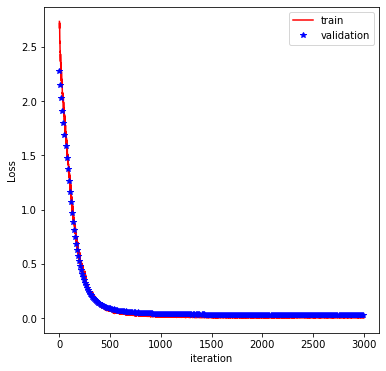

In [28]:
# Plot training and test loss
t = np.arange(iteration-1)

plt.figure(figsize = (6,6))
plt.plot(t, np.array(train_loss), 'r-', t[t % 10 == 0], np.array(validation_loss), 'b*')
plt.xlabel("iteration")
plt.ylabel("Loss")
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

# Accuracies

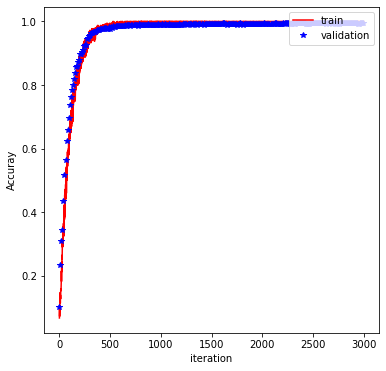

In [30]:
# Plot Accuracies
plt.figure(figsize = (6,6))

plt.plot(t, np.array(train_acc), 'r-', t[t % 10 == 0], validation_acc, 'b*')
plt.xlabel("iteration")
plt.ylabel("Accuray")
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

# EVALUATE ON TEST SET

In [31]:
test_acc = []

with tf.Session(graph=graph) as sess:
    # Restore
    saver.restore(sess, tf.train.latest_checkpoint('checkpoints-cnn'))
    
    for x_t, y_t in get_batches(X_test, y_test, batch_size):
        feed = {inputs_: x_t,
                labels_: y_t,
                keep_prob_: 1}
        
        batch_acc = sess.run(accuracy, feed_dict=feed)
        test_acc.append(batch_acc)
    print("Test accuracy: {:.6f}".format(np.mean(test_acc)))

INFO:tensorflow:Restoring parameters from checkpoints-cnn\mHealth.ckpt
Test accuracy: 0.992500
